
# Starter's Guide to building a CNN with keras (TF), openCV and google drive for image storage

This guide is meant to be a simple tutorial which lets you take images classes, train a model with tensorflow and then predict a new image with your "intelligent" model.

Here is further explanation in a short medium post: https://medium.com/@chibuk/machine-learning-for-the-everyday-person-part-3-your-first-neural-network-744528595c65

You can use this python script to get sample training images from a website: https://github.com/ibbad/image-scrapper

To have this notebook work you will need to:
- Have a google drive folder; copy this notebook to it
- Put the notebook and training images in a separate folder e.g. drive/Simple CNN Tutorial/
- Images: https://drive.google.com/drive/folders/1RcWFv-PDtGK4n1JgkAgL77fB-N0I4oMP?usp=sharing

To run this notebook select each cell and click shift+enter on your keyboard, wait until the cell is finished running before going to the next

Below outline the standard import and installation settings for openCV and tensorflow

In [0]:
# STEP 1

# #This section is base copy from google's sample import of tensorflow, keras, ploting and support libraries

#keras install libraries
!pip install -q keras
!pip install -q tqdm

#openCV is used to process and filter images
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [4]:
# STEP 2
# In this step we import the libraries needed to import files from google drive

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmp_jt55g8e/pubring.gpg' created
gpg: /tmp/tmp_jt55g8e/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# STEP 3
# Generate auth tokens for Colab

# CLICK THE LINK GENERATED THEN COPY AND PASTE THE KEY INTO THE FIELD AND CLICK ENTER
from google.colab import auth
auth.authenticate_user()

In [5]:
# STEP 4
# Here we connect to your google drive folder.
# You can download sample puppy and rabbit images using this link: https://drive.google.com/drive/folders/1RcWFv-PDtGK4n1JgkAgL77fB-N0I4oMP?usp=sharing

# WARNING YOU MAY NEED TO RUN THIS CELL MULTIPLE TIMES TO GET A CONNECTION + KEY ESTABLISHED to your google drive.

# CLICK THE 1st LINK GENERATED THEN COPY AND PASTE THE KEY INTO THE FIELD AND CLICK ENTER

# RE-RUN THIS CELL AND CLICK THE 2nd LINK GENERATED THEN COPY AND PASTE THE KEY INTO THE FIELD AND CLICK ENTER

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
··········


In [6]:
# STEP 5
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

# print 'Files in Drive:'
!ls drive/

Colab Notebooks  Development


In [0]:
# STEP 6
import os
os.chdir("drive/Colab Notebooks/Simple CNN Image Tutorial/")

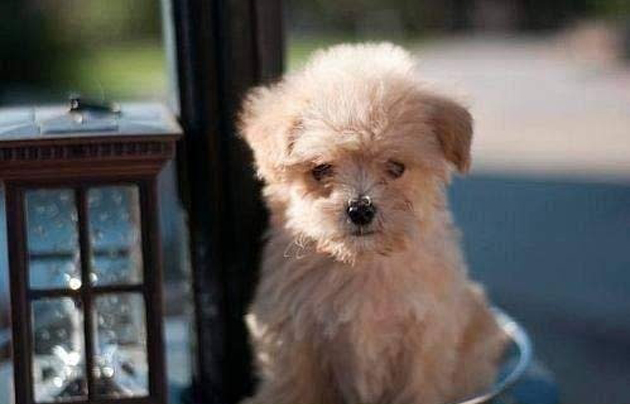

In [8]:
# STEP 7
img_folder = 'images'

#1. Get sample file
#2. Read image and display
from IPython.display import Image
Image("Cute-puppy-photos-82.jpg")

In [9]:
# STEP 8
# This cell contains all the references to libraries that are needed to train a convolutional neural network
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle

from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt

from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


Image Classifier Code from: https://github.com/pranavj1001/Image-Classification/blob/master/CNN_Classification.py

For tips on how to set the number of epochs, steps per epoch and validation size
Please read this https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network

The model below has been lowered to reduce the runtime of the training process given ~100 images in your training class



In [0]:
# STEP 9
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
# make 32 feature detectors with a size of 3x3
# choose the input-image's format to be 64x64 with 3 channels
classifier.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation="relu"))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(32, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(activation="relu", units=128))
classifier.add(Dense(activation="sigmoid", units=1))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

# augment the data that we have
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

# prepare training data
training_data = train_datagen.flow_from_directory('./images/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

# prepare test data
test_data = test_datagen.flow_from_directory('./images/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

# finally start computation
# to improve the model accuracy you can increase the number of steps_per_epoch to e.g. 8000
# increase the number of epochs to 5-25
# increase the validation steps
# this parametters allow for the model to optimize

classifier.fit_generator(training_data,
                         steps_per_epoch = (4000 / 32),
                         epochs = 1,
                         validation_data = test_data,
                         validation_steps = 2000)

Found 152 images belonging to 2 classes.
Found 23 images belonging to 2 classes.
Epoch 1/1
124/125 [============================>.] - ETA: 1s - loss: 0.4717 - acc: 0.7783

In [48]:
# STEP 10

from IPython.display import Image
Image("./newimages/bunny3.jpg")

# to make predictions
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('./newimages/puppy3.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
# training_set.class_indices
if result[0][0] == 1:
    prediction = 'puppy'
else:
    prediction = 'bunny'
    
print(result)
print(prediction)

[[1.]]
puppy
